This notebook is devoted to implementing periodic boundary conditions. These boundary conditions are often used to approximate a very large system by taking a small region, called a unit cell, which can be replicated over the entire system, hence the term periodic. 

Firstly, we describe the equation we would like to solve:

$$ \frac{\partial U}{\partial t} + a \frac{\partial U}{\partial x} = 0, $$
where $U = u_mh_m$.

Mathematically, periodic boundary conditions means that the solution should be periodic in this large system, i.e., if we take a domain and apply periodic boundary conditions, this domain will be one of the many copies, stacked one after the other. When we deal with the central difference scheme, we end with two unknowns, at each of the extremes. If our unit cell comprises of N grid points, labelled as $x_1,x_2,x_3...,x_N$, then the 0th grid point should actually be equal to the Nth grid point, and the (N+1)th grid point should be equal to the 1st grid point. For an arbitrary function $f(x)$, this can be stated as:

$$ f(x = x_1) = f(x = x_N+1), $$

$$ f(x = x_N) = f(x = 0).$$

The general form of analytical solution for this equation is:

$$ U(x,t) = A sin(k(x - at)) + B. $$

We consider a full sine wave (so that we can apply periodic boundary conditions, and we check a specific solution:

$$ U(x,t) = -h_m \times sin \Big(\frac{2 \pi x}{L_x} \Big), $$
where $h_m$ is the mixed layer height, and in this notebook, is spatially and temporally constant ($= 150 m$).

For both cases, the numerical and analytical solution match.

# Test 1: Solving a "pseudo-conservative" form

In this case, we do solve the equation mentioned above, but during the itertion, we solve for $u_mh_m$ by dividing the whole equation with $h_m$.

In [ ]:
import Euler.Euler1D as elr

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys

In [28]:
#Length of domain
Lx = 100

# Number of points
nx = 25

#Width of each cell
dx = Lx/nx


g = 9.81
rho0 = 1025

# An array for storing each point of domain
xu_ocean = np.linspace(0,Lx,nx+1,dtype = float)

#Dropping the last point (needed to implement periodic BC)
xu_ocean = xu_ocean[0:-1]

In [29]:
def partial_x(f, dx):
    """This function computes the partial derivative of x (Default: Backward difference)
    
    -------------------------------------------------------------------------------------
    Arguments:
    f: Function which needs to be differentiated
    dx: Width of each cell
    -------------------------------------------------------------------------------------
    Returns:
    dfdx: Partial derivative of f
    """
    
    dfdx = np.zeros_like(f)
    for j in range(f.size):
        dfdx[j] = 1/(dx) * (f[j]-f[j-1])    #Backward difference

    return dfdx

def adv_x_Euler(f1,hm_old,hm_new):
    """This function performs 1D advection on a tracer/momentum variable with constant speed
    
    -------------------------------------------------------------------------------------
    Arguments:
    f1: Variable which needs to be advected
    hm_old: Mixed layer height at previous time step
    hm_old: Mixed layer height at current time step
    -------------------------------------------------------------------------------------
    Returns:
    f3: Array with advected variable
    """

    f3 = -(1/hm_new)*a*partial_x(hm_old*f1,dx)
    return f3

In [30]:
#Initialising variables
MLD_0 = -150*np.ones(nx)
um_old = np.sin(2*np.pi*xu_ocean/(Lx))
um_new = np.zeros(nx)
hm_old = -MLD_0
hm_new = hm_old

a = 1 #Speed of advection

#Time variables
t_start = 0
t_end = 40
dt = 2

#True solution
um_true = np.sin(2*np.pi*xu_ocean/(Lx))

#Advecting the variable for fixed number of time steps
for t in np.arange(t_start,t_end,dt):
    um_new = um_old + dt*adv_x_Euler(um_old,hm_old,hm_new)
    um_true = np.sin(2*np.pi*(xu_ocean - a*t)/Lx)
    um_old = um_new

Text(0.5, 1.0, 'Backward difference')

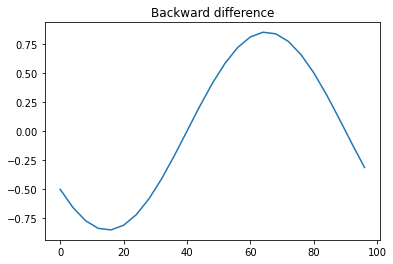

In [31]:
plt.plot(xu_ocean,um_new)
plt.title('Backward difference')

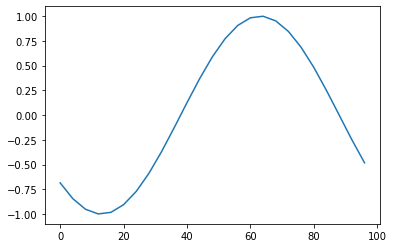

In [32]:
plt.plot(xu_ocean,um_true)

# Test 2: Using the real conservative form

In this case, we solve the fully conservative form, i.e., we solve for $U$. In both the cases, we see that the central difference starts to induce oscillations from the boundaries. 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import sys

In [70]:
Lx = 100
nx = 40
dx = Lx/nx
g = 9.81
rho0 = 1025

xu_ocean = np.linspace(0,Lx,nx+1,dtype = float)
xu_ocean = xu_ocean[0:-1]

In [3]:
def partial_x(f, dx):
    
    """This function computes the partial derivative of x (Default: Backward difference)
    
    -------------------------------------------------------------------------------------
    Arguments:
    f: Function which needs to be differentiated
    dx: Width of each cell
    -------------------------------------------------------------------------------------
    Returns:
    dfdx: Partial derivative of f
    """
    
    dfdx = np.zeros_like(f)
    for j in range(f.size):
        dfdx[j] = 1/(dx) * (f[j]-f[j-1])    #Backward difference

    return dfdx

def adv_x_Euler(f1):
    
    """This function performs 1D advection on a tracer/momentum variable with constant speed
    
    -------------------------------------------------------------------------------------
    Arguments:
    f1: Variable which needs to be advected
    -------------------------------------------------------------------------------------
    Returns:
    f3: Array with advected variable
    """
    
    f3 = -a*partial_x(f1,dx)
    return f3

In [72]:
#Initialising variables
MLD_0 = -150*np.ones(nx)

hm_old = -MLD_0
hm_new = hm_old
U_old = (np.sin(2*np.pi*xu_ocean/Lx))*(hm_old)
U_new = np.zeros(nx)

#Time variables
t_start = 0
t_end = 80
dt = 2

a = 0.5 #Speed of advection

#True solution
U_true = (np.sin(2*np.pi*xu_ocean/Lx))*(hm_old)
U_true_0 = (np.sin(2*np.pi*xu_ocean/Lx))*(hm_old)

for t in np.arange(t_start,t_end,dt):
    U_new = U_old + dt*adv_x_Euler(U_old)
    
    U_true = (np.sin(2*np.pi*(xu_ocean - a*t)/Lx))*(hm_old)

    U_old = U_new

Text(0.5, 1.0, 'Depth integrated velocity(m/s) - Backward difference')

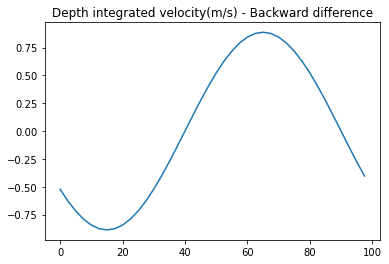

In [81]:
plt.plot(xu_ocean,U_new/hm_new)
plt.title('Depth integrated velocity(m/s) - Backward difference')

Text(0.5, 1.0, 'Depth integrated velocity(m/s) - Analytical solution')

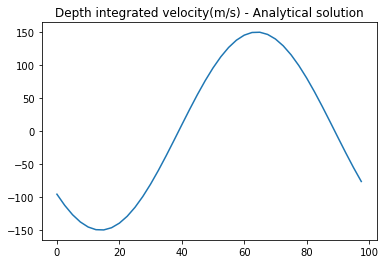

In [82]:
plt.plot(xu_ocean,U_true)
plt.title('Depth integrated velocity(m/s) - Analytical solution')

# Test 3: Error analysis

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys

In [32]:
Lx = 100
g = 9.81
rho0 = 1025

nx = [4,8,32,64,128,256,512,1024,2048,4096,8192]
error_U = np.zeros(len(nx))

for i,nxi in enumerate(nx):
    dx = Lx/nxi
    
    xu_ocean = np.linspace(0,Lx,nxi+1,dtype = float)
    xu_ocean = xu_ocean[0:-1]
    
    MLD_0 = -150*np.ones(nxi)

    hm_old = -MLD_0
    hm_new = hm_old
    U_old = (np.sin(2*np.pi*xu_ocean/(Lx)))*(hm_old)
    U_new = np.zeros(nxi)

    a = 0.5 #Speed of advection

    t_start = 0
    t_end = 20
    dt = 0.01
    for t in np.arange(t_start,t_end,dt):
        U_new = U_old + dt*adv_x_Euler(U_old)
        U_old = U_new
        
    BC = (np.sin(2*np.pi*(xu_ocean - a*t)/(Lx)))*hm_new
    error_U[i] = max(abs(U_new - BC))

In [33]:
nx_inv = np.zeros(len(nx))
nx2_inv = np.zeros(len(nx))
for i,nxi in enumerate(nx):
    nx_inv[i] = 1/nxi
    nx2_inv[i] = 1/nxi**2

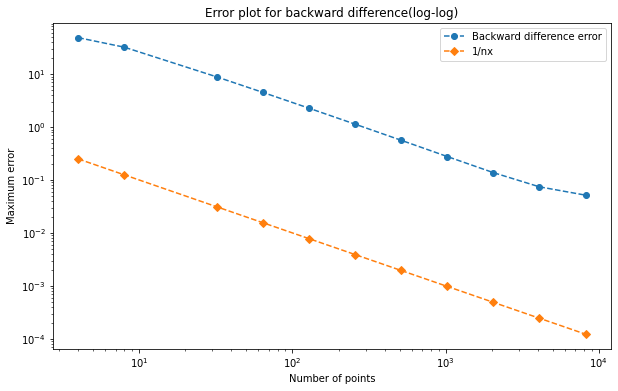

In [34]:
plt.figure(figsize = (10,6))
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Number of points")
plt.ylabel("Maximum error")
plt.plot(nx,error_U,marker='o',linestyle = '--',label = 'Backward difference error')
plt.plot(nx,nx_inv,marker = 'D',linestyle = '--', label = '1/nx')
plt.title("Error plot for backward difference(log-log)")
plt.legend()
plt.show()